# Data wrangling of Properties

Environment: Jupyter notebook

Libraries used in the task:
* pandas (for storing and and analyzing data) 
* numpy (for data computations) 
* matplotlib (for data visualization)
* scikit-learn (for standardising data)
* statsmodels (for linear regression and partial regression plots)
* math (for applying trigonometric, power and logarithmic functions)
* datetime (for parsing dates)
* beautifulsoup4 (for viewing the structure of xml files)
* ElementTree (for parsing xml files)
* pyshp (for reading shape file)
* shapely (for solving the point in polygon problem)

## 1. Introduction
The notebook does 2 major tasks: Data Integration and Data Reshaping.  

The objective of the data integration task is to integrate 7 different data files in various formats such as xml, json, html, xlsx, gtfs and shapefiles. The data files are about house properties; the 2 real estate files contain information about the properties such as number of bedrooms, bathroom, year of property, price of the property, geocoordinates of the property. The shopping centres, supermarkets  and hospitals files have the list of shopping centres, supermarkets and hospitals respectively with their geocoordinates. The nearest utility to the property is found using these files and integrated in the consolided database of properties. The "VIC Boundary" shapefile has the boundaries of the suburbs in Melbourne. It is used to find the suburb of the properties. The GTFS file has information about Melbourne trains, and is used to find the nearest station to the property and the travel time to CBD.  

The objective of the data reshaping task is to perform various normalisation and transformations to the property price. These transformations are compared against each other. Finally, the transformations are contrasted against each other to fit a linear model for property price using the appropriate predictors. The best transformation for property price is finally recommended for a linear model.

In [1]:
# Code to import libraries that are needed for this task:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from bs4 import BeautifulSoup
import xml.etree.ElementTree as etree    
from math import sin, cos, sqrt, atan2, radians, floor, log10, sqrt
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import shapefile
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
%matplotlib inline

## 2. Data Integration

### 2.1 Real Estate files
Let us start the data integration process by first loading the real estate files:

In [2]:
# loading json real estate file
real_state_json = pd.read_json('Raw_Files/real_state.json')
real_state_json.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
0,24 Newham Grove,1.0,2.0,-37.901534,145.039038,1.0,6743000.0,95272.0,house,2011.0
1,12 Mundy Street,1.0,3.0,-37.707201,145.077326,2.0,11390000.0,43462.0,house,2015.0
2,59 Girgarre Street,1.0,3.0,-37.668110,144.920118,1.0,4565000.0,19034.0,house,2013.0
3,93 Barry Street,1.0,3.0,-37.709055,144.997929,1.0,5330000.0,35788.0,house,2013.0
4,5A Governor Road,1.0,3.0,-38.009631,145.093150,2.0,6750000.0,93529.0,house,2016.0


Summary of the real estate json data file:

In [3]:
print(real_state_json.shape)
real_state_json.describe()

(1010, 10)


,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,year
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1.006000e+03,1006.000000,1006.000000
mean,1.576541,3.221670,-37.807521,145.040437,1.567594,9.108108e+06,48606.748509,2012.324056
std,0.616204,0.772389,0.101627,0.135832,0.798571,5.996252e+06,27976.709961,2.614608
min,1.000000,1.000000,-38.079700,144.633182,0.000000,1.528000e+06,114.000000,2006.000000
25%,1.000000,3.000000,-37.867355,144.956444,1.000000,5.285000e+06,25121.750000,2010.000000
50%,2.000000,3.000000,-37.801473,145.036828,2.000000,7.465500e+06,48088.500000,2013.000000
75%,2.000000,4.000000,-37.733684,145.124596,2.000000,1.092825e+07,72735.500000,2015.000000
max,3.000000,5.000000,-37.570812,145.365466,3.000000,4.590000e+07,96509.000000,2016.000000


There are 1010 properties in this file with information such as bathrooms, bedrooms, address, geocordinates, year, parking spaces and price. However, note that there are only 1006 property IDs.  

Check the records where the property ID is null:

In [4]:
real_state_json.loc[real_state_json['property_id'].isna(),]

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
550,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
592,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
609,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
625,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


There are few rows where all the values are null. Dropping such rows with all values:

In [5]:
real_state_json.dropna(subset = ['property_id'], inplace = True)
real_state_json.shape

(1006, 10)

Check for any duplicate property IDs:

In [6]:
real_state_json['property_id'].value_counts().head(10)

74955.0    3
93625.0    2
19034.0    2
4610.0     2
59157.0    1
38743.0    1
23125.0    1
12980.0    1
26872.0    1
56839.0    1
Name: property_id, dtype: int64

Some property IDs are same. Check the records with same property IDs:

In [7]:
# some IDs are same
count_ids = real_state_json['property_id'].value_counts()
repeated_ids = count_ids[count_ids > 1].index
real_state_json.loc[real_state_json['property_id'].isin(repeated_ids),].sort_values(['property_id'])

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
296,67 William Street,1.0,2.0,-37.837910,144.879532,1.0,4230000.0,4610.0,house,2009.0
333,67 William Street,1.0,2.0,-37.837910,144.879532,1.0,4230000.0,4610.0,house,2009.0
2,59 Girgarre Street,1.0,3.0,-37.668110,144.920118,1.0,4565000.0,19034.0,house,2013.0
204,59 Girgarre Street,1.0,3.0,-37.668110,144.920118,1.0,4565000.0,19034.0,house,2013.0
467,2B Hunter Street,3.0,3.0,-37.905554,145.057771,2.0,13580000.0,74955.0,house,2013.0
633,2B Hunter Street,3.0,3.0,-37.905554,145.057771,2.0,13580000.0,74955.0,house,2013.0
678,2B Hunter Street,3.0,3.0,-37.905554,145.057771,2.0,13580000.0,74955.0,house,2013.0
541,7 Francis Street,1.0,4.0,-38.001036,145.091542,2.0,10175000.0,93625.0,house,2010.0
626,7 Francis Street,1.0,4.0,-38.001036,145.091542,2.0,10175000.0,93625.0,house,2010.0


The rows with same property IDs have the same values. We can drop the records with same property ID.

In [8]:
# finding IDs to drop
dup_ids_logical = (real_state_json["property_id"].duplicated(keep = 'first')) 
dup_ids = real_state_json.loc[dup_ids_logical,"property_id"] # Store the duplicate IDs that appears second
dup_ids

204    19034.0
333     4610.0
626    93625.0
633    74955.0
678    74955.0
Name: property_id, dtype: float64

Dropping duplicated row that comes second:

In [9]:
real_state_json.drop(dup_ids.index, axis=0, inplace=True)
real_state_json.shape

(1001, 10)

We now have 1001 properties in the dataset.  

Loading the other real estate xml file:
First step, is to read the first few rows of the xml file to understand the structure of the file.

In [10]:
real_state_tree = BeautifulSoup(open("Raw_Files/real_state.xml"),"lxml-xml")   
print(real_state_tree.prettify())

<?xml version="1.0" encoding="utf-8"?>
<root>
 <bathrooms type="dict">
  <n19491 type="number">
   1.0
  </n19491>
  <n40159 type="number">
   3.0
  </n40159>
  <n65096 type="number">
   2.0
  </n65096>
  <n59709 type="number">
   1.0
  </n59709>
  <n33323 type="number">
   1.0
  </n33323>
  <n73391 type="number">
   2.0
  </n73391>
  <n19492 type="number">
   2.0
  </n19492>
  <n11542 type="number">
   nan
  </n11542>
  <n39651 type="number">
   2.0
  </n39651>
  <n82297 type="number">
   1.0
  </n82297>
  <n17295 type="number">
   2.0
  </n17295>
  <n35788 type="number">
   1.0
  </n35788>
  <n35626 type="number">
   1.0
  </n35626>
  <n82763 type="number">
   2.0
  </n82763>
  <n1948 type="number">
   2.0
  </n1948>
  <n19017 type="number">
   1.0
  </n19017>
  <n9288 type="number">
   2.0
  </n9288>
  <n21637 type="number">
   1.0
  </n21637>
  <n88482 type="number">
   2.0
  </n88482>
  <n1658 type="number">
   1.0
  </n1658>
  <n90056 type="number">
   1.0
  </n90056>
  <n33422 t

It looks like the xml file has similar information to the real estate json file for newer properties. Parsing the xml file using Element tree library:

In [11]:
tree = etree.parse("Raw_Files/real_state.xml") 
root = tree.getroot()     
root.tag

'root'

In [12]:
# finding all columns in this file
col = []
for child in root:
    col.append(child.tag)
col

['bathrooms',
 'price',
 'bedrooms',
 'parking_space',
 'year',
 'lat',
 'lng',
 'property_type',
 'addr_street',
 'property_id']

Note that these features are the same as those present in the real estate json file. Hence, we can integrate the real estate json and xml files row-wise.  

Extracting the features of the properties in the xml file:  
Before we do the extraction, let us check that the order of the features is same for properties in the xml file.

In [13]:
# quality check that property ids are in the same order for each feature
real_state_tag = {}
for child in root:
    real_state_tag[child.tag] = []
    for sub_child in child:
        real_state_tag[child.tag].append(sub_child.tag)

real_state_xml_tag = pd.DataFrame(real_state_tag)
real_state_xml_tag['QC'] = (real_state_xml_tag['bathrooms'] == real_state_xml_tag['price']) & (
                            real_state_xml_tag['bedrooms'] == real_state_xml_tag['price']) & ( 
                            real_state_xml_tag['parking_space'] == real_state_xml_tag['price']) & (
                            real_state_xml_tag['year'] == real_state_xml_tag['price']) & (
                            real_state_xml_tag['lat'] == real_state_xml_tag['price']) & (
                            real_state_xml_tag['lng'] == real_state_xml_tag['price']) & (
                            real_state_xml_tag['property_type'] == real_state_xml_tag['price']) & (
                            real_state_xml_tag['addr_street'] == real_state_xml_tag['price']) & (
                            real_state_xml_tag['property_id'] == real_state_xml_tag['price'])
real_state_xml_tag['QC'].describe()

count     1004
unique       1
top       True
freq      1004
Name: QC, dtype: object

Now we know that the children for each feature (values corresponding to property) are in the same order. Creating a data frame for the xml data:

In [14]:
real_state_dict = {}
for child in root:
    real_state_dict[child.tag] = []
    for sub_child in child:
        real_state_dict[child.tag].append(sub_child.text)

real_state_xml = pd.DataFrame(real_state_dict)
real_state_xml.head()

,bathrooms,price,bedrooms,parking_space,year,lat,lng,property_type,addr_street,property_id
0,1.0,3900000.0,3.0,0.0,2008.0,-37.65868378,144.9272003,house,76 LONGFORD CRESCENT,19491.0
1,3.0,15300000.0,4.0,2.0,2011.0,-37.705048,145.04792,house,25 Oakden Drive,40159.0
2,2.0,4136000.0,4.0,1.0,2015.0,-37.801066,145.319433,house,11/31 Durham Road,65096.0
3,1.0,7950000.0,3.0,3.0,2011.0,-37.821973,145.212021,house,25 Good Governs Street,59709.0
4,1.0,9900000.0,3.0,1.0,2015.0,-37.736731,145.004787,house,97 Pender Street,33323.0


Similar to json file, check for null property IDs in the xml file:

In [15]:
# Cheking for nulls in property ID
real_state_xml['property_id'] = real_state_xml['property_id'].astype('float64')
real_state_xml.loc[real_state_xml['property_id'].isna(),]

,bathrooms,price,bedrooms,parking_space,year,lat,lng,property_type,addr_street,property_id
7,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN
130,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN
587,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN
840,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN


Dropping rows with all null values:

In [16]:
real_state_xml.dropna(subset = ['property_id'], inplace = True)
real_state_xml.shape

(1000, 10)

We have 1000 properties in the xml file.  

Convert the columns in the real estate xml file to their right data types:

In [17]:
# Converting all columns in real_state_xml to correct data type
real_state_xml.iloc[:,:7] = real_state_xml.iloc[:,:7].astype('float64')
real_state_xml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 1003
Data columns (total 10 columns):
bathrooms        1000 non-null float64
price            1000 non-null float64
bedrooms         1000 non-null float64
parking_space    1000 non-null float64
year             1000 non-null float64
lat              1000 non-null float64
lng              1000 non-null float64
property_type    1000 non-null object
addr_street      1000 non-null object
property_id      1000 non-null float64
dtypes: float64(8), object(2)
memory usage: 85.9+ KB


We have 1001 property IDs in the json file and 1000 property IDs in the xml file. Check for any common property IDs in the files:

In [18]:
# check if property ids are same or different in the xml and json files
consolidated_ids = pd.concat([real_state_json['property_id'], real_state_xml['property_id']], ignore_index = True)
consolidated_ids.value_counts().head()

89989.0    2
48619.0    2
2588.0     2
19034.0    2
17533.0    2
Name: property_id, dtype: int64

There are some property IDs that are common in both the files. We will need to see the records with the same property ID after integrating the two files.  

Integrating real estate xml and json files:

In [19]:
# merging the two data sets
real_state = pd.concat([real_state_json, real_state_xml], ignore_index = True, sort = True)
print(real_state.shape)
real_state.head()

(2001, 10)


,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
0,24 Newham Grove,1.0,2.0,-37.901534,145.039038,1.0,6743000.0,95272.0,house,2011.0
1,12 Mundy Street,1.0,3.0,-37.707201,145.077326,2.0,11390000.0,43462.0,house,2015.0
2,59 Girgarre Street,1.0,3.0,-37.668110,144.920118,1.0,4565000.0,19034.0,house,2013.0
3,93 Barry Street,1.0,3.0,-37.709055,144.997929,1.0,5330000.0,35788.0,house,2013.0
4,5A Governor Road,1.0,3.0,-38.009631,145.093150,2.0,6750000.0,93529.0,house,2016.0


Checking the records with the same property ID:

In [20]:
count_cons_ids = real_state['property_id'].value_counts()
repeated_cons_ids = count_cons_ids[count_cons_ids > 1].index
real_state.loc[real_state['property_id'].isin(repeated_cons_ids),].sort_values(by = "property_id").head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
683,1 Barrett Court,1.0,3.0,-37.814825,144.879006,3.0,4940000.0,2588.0,house,2006.0
1662,1 Barrett Court,1.0,3.0,-37.814825,144.879006,3.0,4940000.0,2588.0,house,2006.0
1754,14 Hood Street,1.0,4.0,-37.811764,144.887878,1.0,7425000.0,2840.0,house,2009.0
8,14 Hood Street,1.0,4.0,-37.811764,144.887878,1.0,7425000.0,2840.0,house,2009.0
1378,3/199 Woods Street,2.0,3.0,-37.845015,144.867274,2.0,5200000.0,4347.0,house,2015.0


The records with the same property ID are duplicates. Deleting the duplicated record that comes second:

In [21]:
# delete duplicates in consolidated data
dup_cons_ids_logical = (real_state.duplicated(keep = 'first')) 
dup_cons_ids = real_state.loc[dup_cons_ids_logical,"property_id"] # Store the duplicate IDs that appears second for deleting
len(dup_cons_ids)

30

There are 30 duplicate rows in the files. Deleting these 30 rows:

In [22]:
real_state.drop(dup_cons_ids.index, axis=0, inplace=True)
real_state.shape

(1971, 10)

We now have 1971 properties in the consolidated real estate data frame.  

### 2.2 Nearest Shopping Centre

Reading the file with information about shopping centres:

In [23]:
sc_html = pd.read_html('Raw_Files/shopingcenters.html', header = 0, index_col = 0)
sc_html = sc_html[0] # only 1 table
sc_html.head() # quality check

,sc_id,lat,lng
0,SC_001,-37.767915,145.041790
1,SC_002,-37.819375,145.171472
2,SC_003,-37.971131,145.089065
3,SC_004,-35.280406,149.132550
4,SC_005,-37.574572,144.920451


This file has the list of the shopping centres and their geocoordinates.  

Defining a function to compute the nearest Shopping centre to the property:  
For computing the distances, we first need a function to complete the distance between 2 geocoordinates using the Havesine formula.

In [24]:
# Distance between two points using the fomula for latitudes and longitudes
# Reference 1 #https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
R = 6378.0 # radius of earth

def computedDistance(org_lat,dest_lat,org_long,dest_long):
    org_lat = radians(org_lat)
    dest_lat = radians(dest_lat)
    org_long = radians(org_long)
    dest_long = radians(dest_long)

    dlat = dest_lat - org_lat
    dlon = dest_long - org_long
    
    a = sin(dlat / 2)**2 + cos(org_lat) * cos(dest_lat) * sin(dlon / 2)**2
    b = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = round(R * b,3) * 1000
    return distance

In [25]:
def nearestSC(prop_lat,prop_lng):
    sc_html['Distance'] = np.vectorize(computedDistance)(sc_html['lat'], prop_lat,sc_html['lng'],prop_lng)
    min_idx = sc_html['Distance'].idxmin(axis = 0)
    return sc_html.iloc[min_idx,0]
# testing
a = nearestSC(-37.8,145.23)
print(a)

SC_032


It looks like the function is working, applying the function to the real estate data frame to calculate the nearst shopping centre:

In [26]:
real_state['shopping_center_id'] = np.vectorize(nearestSC)(real_state['lat'],real_state['lng'])
real_state.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,shopping_center_id
0,24 Newham Grove,1.0,2.0,-37.901534,145.039038,1.0,6743000.0,95272.0,house,2011.0,SC_041
1,12 Mundy Street,1.0,3.0,-37.707201,145.077326,2.0,11390000.0,43462.0,house,2015.0,SC_047
2,59 Girgarre Street,1.0,3.0,-37.668110,144.920118,1.0,4565000.0,19034.0,house,2013.0,SC_072
3,93 Barry Street,1.0,3.0,-37.709055,144.997929,1.0,5330000.0,35788.0,house,2013.0,SC_103
4,5A Governor Road,1.0,3.0,-38.009631,145.093150,2.0,6750000.0,93529.0,house,2016.0,SC_003


Computing the distance from the property to the nearest shopping centre:

In [27]:
def distanceToSC(prop_lat,prop_lng):
    sc_html['Distance'] = np.vectorize(computedDistance)(sc_html['lat'], prop_lat,sc_html['lng'],prop_lng)
    min_idx = sc_html['Distance'].idxmin(axis = 0)
    return sc_html.iloc[min_idx,3]

real_state['distance_to_sc'] = np.vectorize(distanceToSC)(real_state['lat'],real_state['lng'])
real_state['distance_to_sc'].describe()

count    1971.000000
mean     2583.958397
std      1410.182222
min       195.000000
25%      1443.500000
50%      2322.000000
75%      3491.500000
max      5974.000000
Name: distance_to_sc, dtype: float64

The distances to the nearest shopping centre seem to make sense. Note that the distances are in metres.  

### 2.3 Nearest Hospital

Reading the file with the list of hospitals and their geocoordinates:

In [28]:
# Closest Hospital
hospitals_json = pd.read_json('Raw_Files/hospitals.json')
hospitals_json.head()

,id,lat,lng,name
0,hospital_001,-37.990622,145.072836,Como Private Hospital
1,hospital_002,-37.855469,145.268183,Mountain District Private Hospital
2,hospital_003,-37.792230,144.889128,Western Hospital
3,hospital_004,-37.756042,145.061896,Mercy Hospital for Women
4,hospital_005,-37.760623,144.815624,Sunshine Hospital


Similar to the shopping centres, defining functions to compute the nearest hospital to the property and the distance between the nearest hospital and the property:

In [29]:
def nearestHospital(prop_lat,prop_lng):
    hospitals_json['Distance'] = np.vectorize(computedDistance)(hospitals_json['lat'], prop_lat,
                                                            hospitals_json['lng'],prop_lng)
    min_idx = hospitals_json['Distance'].idxmin(axis = 0)
    return hospitals_json.iloc[min_idx,0]
# testing
a = nearestHospital(-37.8,145.23)
print(a)
def distanceToHospital(prop_lat,prop_lng):
    hospitals_json['Distance'] = np.vectorize(computedDistance)(hospitals_json['lat'], prop_lat,
                                                            hospitals_json['lng'],prop_lng)
    min_idx = hospitals_json['Distance'].idxmin(axis = 0)
    return hospitals_json.iloc[min_idx,4]
# testing
b = distanceToHospital(-37.8,145.23)
print(b)

hospital_105
1691.0


It looks like the functions are working correctly. Applying the functions to the entire data frame:

In [30]:
real_state['hospital_id'] = np.vectorize(nearestHospital)(real_state['lat'],real_state['lng'])
real_state['distance_to_hospital'] = np.vectorize(distanceToHospital)(real_state['lat'],real_state['lng'])
real_state.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,shopping_center_id,distance_to_sc,hospital_id,distance_to_hospital
0,24 Newham Grove,1.0,2.0,-37.901534,145.039038,1.0,6743000.0,95272.0,house,2011.0,SC_041,2542.0,hospital_126,1730.0
1,12 Mundy Street,1.0,3.0,-37.707201,145.077326,2.0,11390000.0,43462.0,house,2015.0,SC_047,5414.0,hospital_037,1866.0
2,59 Girgarre Street,1.0,3.0,-37.668110,144.920118,1.0,4565000.0,19034.0,house,2013.0,SC_072,1941.0,hospital_104,1939.0
3,93 Barry Street,1.0,3.0,-37.709055,144.997929,1.0,5330000.0,35788.0,house,2013.0,SC_103,3417.0,hospital_139,948.0
4,5A Governor Road,1.0,3.0,-38.009631,145.093150,2.0,6750000.0,93529.0,house,2016.0,SC_003,4301.0,hospital_001,2766.0


### 2.4 Nearest Supermarket

Reading the supermarkets file:

In [31]:
supermarkets_xls = pd.read_excel('Raw_Files/supermarkets.xlsx', index_col = 0)
supermarkets_xls.head()

,id,lat,lng,type
0,S_001,-37.883978,144.735287,Woolworths
1,S_002,-41.161591,147.514797,Woolworths
2,S_003,-37.984078,145.077167,Woolworths
3,S_004,-37.707023,144.938740,Woolworths
4,S_005,-37.597670,144.938413,Woolworths


Defining functions to compute the nearest supermarket and the distance to the nearest supermarket: 

In [32]:
def nearestSupermarket(prop_lat,prop_lng):
    supermarkets_xls['Distance'] = np.vectorize(computedDistance)(supermarkets_xls['lat'], prop_lat,
                                                            supermarkets_xls['lng'],prop_lng)
    min_idx = supermarkets_xls['Distance'].idxmin(axis = 0)
    return supermarkets_xls.iloc[min_idx,0]
# testing
a = nearestSupermarket(-37.8,145.23)
print(a)
def distanceToSupermarket(prop_lat,prop_lng):
    supermarkets_xls['Distance'] = np.vectorize(computedDistance)(supermarkets_xls['lat'], prop_lat,
                                                            supermarkets_xls['lng'],prop_lng)
    min_idx = supermarkets_xls['Distance'].idxmin(axis = 0)
    return supermarkets_xls.iloc[min_idx,4]
# testing
b = distanceToSupermarket(-37.8,145.23)
print(b)

S_190
1270.0


Applying the functions to the real estate data frame:

In [33]:
real_state['supermarket_id'] = np.vectorize(nearestSupermarket)(real_state['lat'],real_state['lng'])
real_state['distance_to_supermaket'] = np.vectorize(distanceToSupermarket)(real_state['lat'],real_state['lng'])
real_state.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,shopping_center_id,distance_to_sc,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket
0,24 Newham Grove,1.0,2.0,-37.901534,145.039038,1.0,6743000.0,95272.0,house,2011.0,SC_041,2542.0,hospital_126,1730.0,S_107,2021.0
1,12 Mundy Street,1.0,3.0,-37.707201,145.077326,2.0,11390000.0,43462.0,house,2015.0,SC_047,5414.0,hospital_037,1866.0,S_020,2022.0
2,59 Girgarre Street,1.0,3.0,-37.668110,144.920118,1.0,4565000.0,19034.0,house,2013.0,SC_072,1941.0,hospital_104,1939.0,S_153,1119.0
3,93 Barry Street,1.0,3.0,-37.709055,144.997929,1.0,5330000.0,35788.0,house,2013.0,SC_103,3417.0,hospital_139,948.0,S_030,2613.0
4,5A Governor Road,1.0,3.0,-38.009631,145.093150,2.0,6750000.0,93529.0,house,2016.0,SC_003,4301.0,hospital_001,2766.0,S_119,594.0


### 2.5 Suburb  

Reading the VIC Boundaries shapefile that contains the boundaries of the suburbs:

In [34]:
sf = shapefile.Reader("VIC_Boundary/VIC_LOCALITY_POLYGON_shp") 
records = sf.records()
shapes = sf.shapes()

Exploring the number of records, shapes and the content of records in the file:

In [35]:
len(records), len(shapes)

(2973, 2973)

In [36]:
shapes[0].points[:5]

[(141.74552399, -35.07228701),
 (141.74552471, -35.07201624),
 (141.74748471, -35.06367123),
 (141.74909525, -35.05681288),
 (141.74917403, -35.05647197)]

In [37]:
shapes[0].parts

[0]

In [38]:
for each in records[:6]:
    print(each[6])

UNDERBOOL
NURRAN
WOORNDOO
DEPTFORD
YANAC
MINIMAY


The 6th element in the record has the suburb.  

Creating a coordinates column, that has the point data type from shapely library, for all properties in the real estate data frame: 

In [39]:
real_state['Coordinates'] = list(zip(real_state['lng'], real_state['lat']))
real_state['Coordinates'].head()

0    (145.039038, -37.901534)
1    (145.077326, -37.707201)
2     (144.920118, -37.66811)
3    (144.997929, -37.709055)
4     (145.09315, -38.009631)
Name: Coordinates, dtype: object

In [40]:
real_state['Coordinates'] = real_state['Coordinates'].apply(Point)
real_state['Coordinates'].head()

0    POINT (145.039038 -37.901534)
1    POINT (145.077326 -37.707201)
2     POINT (144.920118 -37.66811)
3    POINT (144.997929 -37.709055)
4     POINT (145.09315 -38.009631)
Name: Coordinates, dtype: object

Creating a list of polygons in the boundaries shapefile:

In [41]:
polygons = []
for shape in shapes:
    polygon = Polygon(shape.points)
    polygons.append(polygon)

Defining a function suburb that takes a point as an argument. The function checks the polygon that contains the point and returns the suburb corresponding to that polygon.

In [42]:
def suburb(point):
    boolean = []
    for polygon in polygons:
        result = polygon.contains(point)
        boolean.append(result)
    np_bool = np.array(boolean)
    idx = np.where(np_bool)[0]
    return records[idx[0]][6]

Testing the suburb function: 

In [43]:
a = suburb(real_state['Coordinates'][0])
a

'ORMOND'

It looks like the function is working correctly. Applying the function to the entire real estate data frame:  

In [44]:
real_state['suburb'] = real_state['Coordinates'].apply(suburb)
real_state['suburb'].head()

0          ORMOND
1        WATSONIA
2    BROADMEADOWS
3       RESERVOIR
4      MORDIALLOC
Name: suburb, dtype: object

Dropping the coordinates column in the data frame as it is no longer needed:

In [45]:
# Dropping Coordinates Column
real_state.drop(columns = ['Coordinates'],inplace = True)

### 2.6 Nearest Train Station

Reading the GTFS stops file:

In [46]:
# Closest Train Station
gtfs_stops = pd.read_csv(
    '1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/stops.txt')
gtfs_stops.head()

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922
2,19827,Stony Point Railway Station,Crib Point,-38.374235,145.221837
3,19828,Crib Point Railway Station,Crib Point,-38.366123,145.204043
4,19829,Morradoo Railway Station,Crib Point,-38.354033,145.189602


Defining a function to compute the nearest station and the distance to the nearest station:

In [47]:
def nearestStation(prop_lat,prop_lng):
    gtfs_stops['Distance'] = np.vectorize(computedDistance)(gtfs_stops['stop_lat'], prop_lat,
                                                            gtfs_stops['stop_lon'],prop_lng)
    min_idx = gtfs_stops['Distance'].idxmin(axis = 0)
    return gtfs_stops.iloc[min_idx,0]
# testing
a = nearestStation(-37.8,145.23)
print(a)
def distanceToStation(prop_lat,prop_lng):
    gtfs_stops['Distance'] = np.vectorize(computedDistance)(gtfs_stops['stop_lat'], prop_lat,
                                                            gtfs_stops['stop_lon'],prop_lng)
    min_idx = gtfs_stops['Distance'].idxmin(axis = 0)
    return gtfs_stops.iloc[min_idx,5]
# testing
b = distanceToStation(-37.8,145.23)
print(b)

19902
1771.0


Applying the function to the real estate data frame:

In [48]:
real_state['train_station_id'] = np.vectorize(nearestStation)(real_state['lat'],real_state['lng'])
real_state['distance_to_train_station'] = np.vectorize(distanceToStation)(real_state['lat'],real_state['lng'])
real_state.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,shopping_center_id,distance_to_sc,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket,suburb,train_station_id,distance_to_train_station
0,24 Newham Grove,1.0,2.0,-37.901534,145.039038,1.0,6743000.0,95272.0,house,2011.0,SC_041,2542.0,hospital_126,1730.0,S_107,2021.0,ORMOND,19941,193.0
1,12 Mundy Street,1.0,3.0,-37.707201,145.077326,2.0,11390000.0,43462.0,house,2015.0,SC_047,5414.0,hospital_037,1866.0,S_020,2022.0,WATSONIA,19984,707.0
2,59 Girgarre Street,1.0,3.0,-37.668110,144.920118,1.0,4565000.0,19034.0,house,2013.0,SC_072,1941.0,hospital_104,1939.0,S_153,1119.0,BROADMEADOWS,44817,949.0
3,93 Barry Street,1.0,3.0,-37.709055,144.997929,1.0,5330000.0,35788.0,house,2013.0,SC_103,3417.0,hospital_139,948.0,S_030,2613.0,RESERVOIR,20009,1029.0
4,5A Governor Road,1.0,3.0,-38.009631,145.093150,2.0,6750000.0,93529.0,house,2016.0,SC_003,4301.0,hospital_001,2766.0,S_119,594.0,MORDIALLOC,19863,589.0


### 2.7 Travel time to CBD and Transfer Flag

Reading the GTFS calendar file to identify the service that runs on all weekdays:

In [49]:
gtfs_calendar = pd.read_csv(
    '1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/calendar.txt')
gtfs_calendar.head()

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T2,0,0,0,0,0,1,0,20151009,20151011
1,UJ,0,0,0,0,0,0,1,20151009,20151011
2,T6,0,0,0,0,1,0,0,20151009,20151011
3,T5,1,1,1,1,0,0,0,20151012,20151015
4,T2_1,0,0,0,0,0,1,0,20151016,20151018


In [50]:
gtfs_calendar['mon_to_fri_flag'] = gtfs_calendar['monday'] + gtfs_calendar['tuesday'] + gtfs_calendar['wednesday'] + \
                                    gtfs_calendar['thursday'] + gtfs_calendar['friday']
gtfs_calendar.loc[gtfs_calendar['mon_to_fri_flag'] == 5,]

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date,mon_to_fri_flag
8,T0,1,1,1,1,1,0,0,20151023,20151122,5


**Service ID "T0" runs from Monday to Friday**  

Storing the stop id of Flinders Street Station:

In [51]:
# stop id of flinders street
flinder_st_id_ser = gtfs_stops.loc[gtfs_stops['stop_name'] == "Flinders Street Railway Station",'stop_id']
flinder_st_id = flinder_st_id_ser.tolist()[0]
flinder_st_id

19854

Reading GTFS stop_times file that has information about the arrival and departure time of trips:

In [52]:
gtfs_stop_times = pd.read_csv(
    '1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/stop_times.txt')
gtfs_stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072
3,17182517.T2.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19850,4,NaN,0,0,2899.073349
4,17182517.T2.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19851,5,NaN,0,0,3927.090952


There is no service id in the stop_times file, reading the trips data file to map the trip id and service id:

In [53]:
gtfs_trips = pd.read_csv(
    '1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/trips.txt')
gtfs_trips.head() 

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0


We need only the service id and the trip id. We can delete the remaining columns:

In [54]:
gtfs_service_id = gtfs_trips.loc[:,['service_id','trip_id']]
gtfs_service_id.head()

,service_id,trip_id
0,T0,17067982.T0.2-ALM-F-mjp-1.1.H
1,T0,17067988.T0.2-ALM-F-mjp-1.1.H
2,T0,17067992.T0.2-ALM-F-mjp-1.1.H
3,T0,17067999.T0.2-ALM-F-mjp-1.1.H
4,T0,17068003.T0.2-ALM-F-mjp-1.1.H


Doing a Left Join on the stop_times data frame and the service_id data frame to get the service ids for each trip:

In [55]:
gtfs_stop_times_merged = pd.merge(gtfs_stop_times,gtfs_service_id, how='left')
gtfs_stop_times_merged.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,service_id
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000,T2
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818,T2
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072,T2
3,17182517.T2.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19850,4,NaN,0,0,2899.073349,T2
4,17182517.T2.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19851,5,NaN,0,0,3927.090952,T2


Creating a new data frame including only the T0 service:

In [56]:
print(gtfs_stop_times_merged.shape)
gtfs_stop_times_t0 = gtfs_stop_times_merged.loc[gtfs_stop_times_merged['service_id'] == 'T0',]
gtfs_stop_times_t0.shape

(390305, 10)


(42900, 10)

We now need to incude the records with departure time between 7 AM and 11 AM; note that we need to calculate the average time from the property to CBD on weekdays between 7 AM and 9 AM. A 2 hour buffer is kept so that we do not lose out on the records that contain information about trips that started before 9 AM and reached Flinders Street after 9 AM.  

For retaining the rows with departure times between 7 AM and 11 AM, we need to first convert the departure time column to datetime data type.

In [57]:
pd.options.mode.chained_assignment = None
gtfs_stop_times_t0['departure_time_2'] = pd.to_datetime(gtfs_stop_times_t0['departure_time'], 
                                                      format='%H:%M:%S', errors='coerce')
gtfs_stop_times_t0['departure_time_2'].isna().sum()

511

There are 511 departure times that could not be converted to datetime. Checking these records: 

In [58]:
gtfs_stop_times_t0.loc[gtfs_stop_times_t0['departure_time_2'].isna(), 'departure_time'].head()

9114    24:14:00
9115    24:15:00
9116    24:17:00
9117    24:19:00
9118    24:20:00
Name: departure_time, dtype: object

Fortunately, these departure times are at midnight and are to be deleted. We can go ahead and delete these departure times:

In [59]:
gtfs_stop_times_t0.dropna(subset = ['departure_time_2'], inplace = True)
gtfs_stop_times_t0.shape

(42389, 11)

Defining a function "toKeep" that returns True if the departure time is between 7 and 11, and applying it to the data frame:

In [60]:
def toKeep(datetime):
    if (datetime.hour >= 7) & (datetime.hour < 11):
        return True
    else:
        return False

gtfs_stop_times_t0['to_keep'] = gtfs_stop_times_t0['departure_time_2'].apply(toKeep)
gtfs_stop_times_t0['to_keep'].head()

8568    False
8569    False
8570    False
8571    False
8572    False
Name: to_keep, dtype: bool

Creating a new data frame "filtered_stop_times" that contains the records with departure times between 7 AM and 11 AM:

In [61]:
filtered_stop_times = gtfs_stop_times_t0.loc[(gtfs_stop_times_t0['to_keep'] == True),]
filtered_stop_times.shape

(11900, 12)

Dropping the to_keep column as it is no longer needed:

In [62]:
filtered_stop_times.drop(axis = 0, columns = ['to_keep'], inplace = True)

For computing the average time to CBD, we need to have a list of the trains going to Flinders Street:

In [63]:
# List of trains going to Flinder's Station
flinders_trains = filtered_stop_times.loc[(filtered_stop_times['stop_id'] == flinder_st_id) &
                                (filtered_stop_times['stop_sequence'] != 1),'trip_id'] # train should not start from CBD
flinders_trains.shape

(479,)

There are 479 trains going to Flinders Street.  

Creating a column departure hour that contains the departure our of the train:

In [64]:
def departureHour(time):
    return time.hour
filtered_stop_times['departure_time_hour'] = filtered_stop_times['departure_time_2'].apply(departureHour)
filtered_stop_times['departure_time_hour'].describe()

count    11900.000000
mean         8.306639
std          1.066732
min          7.000000
25%          7.000000
50%          8.000000
75%          9.000000
max         10.000000
Name: departure_time_hour, dtype: float64

The values of departure hour are between 7 and 10, which makes sense since we inlcuded only these records.  

Note that we need to compute the average time to CBD and the direct transfer flag for stations. Creating a data frame with station ids:

In [65]:
stations = filtered_stop_times['stop_id'].values
print(len(stations))
stations_set = set(stations)
print(len(stations_set))

11900
216


There are 216 unique stations for trains in the time window 7 AM to 11 AM

In [66]:
stations_ser = pd.Series(list(stations_set))
stations_df = pd.DataFrame({'train_station_id' : stations_ser})
stations_df.head()

,train_station_id
0,19968
1,19969
2,19970
3,19971
4,19972


Creating a function transfer flag that takes the station id as input and returns the transfer flag of the station. The function checks whether there is atleast one train from that station, departing before 9 AM and is in the list of trains going to Flinders Street. 

In [67]:
def transferFlag(station):
    # list of trains departing after 9 from station
    station_trains = filtered_stop_times.loc[(filtered_stop_times['stop_id'] == station) &
                  (filtered_stop_times['departure_time_hour'] < 9),'trip_id']
    # For each train departing from that station, check if it is in the lsit of trains going to CBD
    for train in station_trains:
        if train in flinders_trains.values:
            return 0
    return 1

Applying the function to the stations data frame:

In [68]:
stations_df['transfer_flag'] = stations_df['train_station_id'].apply(transferFlag)
stations_df['transfer_flag'].isna().sum() # check for missing values in transfer flag

0

In [69]:
stations_df['transfer_flag'].value_counts()

0    207
1      9
Name: transfer_flag, dtype: int64

There are 207 stations with a direct trip to Flinders Street and 9 stations that require a transfer to reach CBD.  

Doing a left join of real estate data frame with stations data frame to add the transfer flag:

In [70]:
real_state_merged = pd.merge(real_state,stations_df, how='left')
real_state_merged.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,shopping_center_id,distance_to_sc,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket,suburb,train_station_id,distance_to_train_station,transfer_flag
0,24 Newham Grove,1.0,2.0,-37.901534,145.039038,1.0,6743000.0,95272.0,house,2011.0,SC_041,2542.0,hospital_126,1730.0,S_107,2021.0,ORMOND,19941,193.0,0.0
1,12 Mundy Street,1.0,3.0,-37.707201,145.077326,2.0,11390000.0,43462.0,house,2015.0,SC_047,5414.0,hospital_037,1866.0,S_020,2022.0,WATSONIA,19984,707.0,0.0
2,59 Girgarre Street,1.0,3.0,-37.668110,144.920118,1.0,4565000.0,19034.0,house,2013.0,SC_072,1941.0,hospital_104,1939.0,S_153,1119.0,BROADMEADOWS,44817,949.0,0.0
3,93 Barry Street,1.0,3.0,-37.709055,144.997929,1.0,5330000.0,35788.0,house,2013.0,SC_103,3417.0,hospital_139,948.0,S_030,2613.0,RESERVOIR,20009,1029.0,0.0
4,5A Governor Road,1.0,3.0,-38.009631,145.093150,2.0,6750000.0,93529.0,house,2016.0,SC_003,4301.0,hospital_001,2766.0,S_119,594.0,MORDIALLOC,19863,589.0,0.0


Checking the number of missing transfer flags and the stations with no direct trip to Flinders Street:

In [71]:
real_state_merged['transfer_flag'].sum() # no. of stations with no direct trip to Flinders Street

0.0

In [72]:
real_state_merged['transfer_flag'].isna().sum() # number of missing transfer flags

2

Getting the station id of the stations with missing transfer flags:

In [73]:
real_state_merged.loc[real_state_merged['transfer_flag'].isna(), 'train_station_id']

622    20027
678    20027
Name: train_station_id, dtype: int64

Only 1 station with id '20027' has no direct trip to Flinders Street.  

Compute the average travel time for stations that have a direct trip to Flinders Street:
First, convert the arrival time to datetime datetype.

In [74]:
# converting arrival time to datetime
filtered_stop_times['arrival_time_2'] = pd.to_datetime(filtered_stop_times['arrival_time'], 
                                                      format='%H:%M:%S', errors='coerce')
filtered_stop_times['arrival_time_2'].isna().sum() # check for missing arrival times

0

Define a function "timeToCBD" that takes the station as argument and returns the average time to CBD on weekdays for trains departing from that station between 7 AM and 9 AM. The method for calculating the average time is as follows:  

* The function finds the list of trains departing from the station before 9 AM
* For each of these trains, check if it goes to Flinders Street. If the train goes to Flinders Street, compute the travel time to Flinders Street for that trip. The travel time is the difference between arrival time at Flinders Street and Departure time from that station
* Add the travel time to an array that contains all the required travel times
* Filter the array for travel times greater than 0 (in other words, consider only the trains from station to CBD and not vice versa), and return the average of the filtered travel times.

In [75]:
def timeToCBD(station):
    # list of trains from station
    station_trains = filtered_stop_times.loc[(filtered_stop_times['stop_id'] == station) & 
                     (filtered_stop_times['departure_time_hour'] < 9),'trip_id'].values
    times = []
    for train in station_trains:
        if train in flinders_trains.values: # check if train goes to CBD
            # store arrival time at flinders street
            a = np.array(filtered_stop_times.loc[(filtered_stop_times['trip_id'] == train) & \
                (filtered_stop_times['stop_id'] == flinder_st_id) ,'arrival_time_2'].values)
            # store departure time at station
            b = np.array(filtered_stop_times.loc[(filtered_stop_times['trip_id'] == train) & \
                (filtered_stop_times['stop_id'] == station),'departure_time_2'].values)
            # compute travel time
            travel_times = a - b
            # append travel time to times list after converting it to from ns to minutes
            travel_times = travel_times.astype('timedelta64[m]')
            times.append(travel_times[0])
    times = np.array(times)
    times = times.astype('int64')
    # filter for travel times > 0
    filtered_times = times[times >= 0]
    if len(filtered_times) > 0:
        return round(np.mean(filtered_times),0) # return mean
    return np.nan

Apply the time to CBD function for the stations data frame:

In [76]:
stations_df['travel_min_to_CBD'] = stations_df['train_station_id'].apply(timeToCBD)
stations_df['travel_min_to_CBD'].isna().sum()

9

Check the 9 stations with missing travel minutes to CBD:

In [77]:
stations_df.loc[stations_df['travel_min_to_CBD'].isna(),]

,train_station_id,transfer_flag,travel_min_to_CBD
75,19827,1,NaN
76,19828,1,NaN
77,19829,1,NaN
78,19830,1,NaN
79,19831,1,NaN
80,19832,1,NaN
81,19833,1,NaN
82,19834,1,NaN
84,19836,1,NaN


This looks correct as the transfer flag is 1 for these stations and there is no direct trip to CBD from these stations.  

Check if there are any stations with transfer flag 1, but have a travel time indicating wrong calculation:

In [78]:
stations_df.loc[stations_df['transfer_flag'] == 1,]

,train_station_id,transfer_flag,travel_min_to_CBD
75,19827,1,NaN
76,19828,1,NaN
77,19829,1,NaN
78,19830,1,NaN
79,19831,1,NaN
80,19832,1,NaN
81,19833,1,NaN
82,19834,1,NaN
84,19836,1,NaN


The stations ids are same as above; the funtion is working correctly. Check the travel time for flinders street station:

In [79]:
stations_df.loc[stations_df['train_station_id'] == flinder_st_id, ]

,train_station_id,transfer_flag,travel_min_to_CBD
102,19854,0,0.0


The travel time from Flinders Street is 0, which is correct. Looks like the function is working fine.

Doing a left join for the real estates data frame and stations to add the travel time to CBD:

In [80]:
real_state_merged = pd.merge(real_state,stations_df, how='left')
real_state_merged.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,...,distance_to_sc,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket,suburb,train_station_id,distance_to_train_station,transfer_flag,travel_min_to_CBD
0,24 Newham Grove,1.0,2.0,-37.901534,145.039038,1.0,6743000.0,95272.0,house,2011.0,...,2542.0,hospital_126,1730.0,S_107,2021.0,ORMOND,19941,193.0,0.0,36.0
1,12 Mundy Street,1.0,3.0,-37.707201,145.077326,2.0,11390000.0,43462.0,house,2015.0,...,5414.0,hospital_037,1866.0,S_020,2022.0,WATSONIA,19984,707.0,0.0,34.0
2,59 Girgarre Street,1.0,3.0,-37.668110,144.920118,1.0,4565000.0,19034.0,house,2013.0,...,1941.0,hospital_104,1939.0,S_153,1119.0,BROADMEADOWS,44817,949.0,0.0,40.0
3,93 Barry Street,1.0,3.0,-37.709055,144.997929,1.0,5330000.0,35788.0,house,2013.0,...,3417.0,hospital_139,948.0,S_030,2613.0,RESERVOIR,20009,1029.0,0.0,33.0
4,5A Governor Road,1.0,3.0,-38.009631,145.093150,2.0,6750000.0,93529.0,house,2016.0,...,4301.0,hospital_001,2766.0,S_119,594.0,MORDIALLOC,19863,589.0,0.0,44.0


Check for missing travel times:

In [81]:
real_state_merged.loc[real_state_merged['travel_min_to_CBD'].isna(),'train_station_id']

622    20027
678    20027
Name: train_station_id, dtype: int64

Only 2 records with station ID '20027' have transfer flag as 1 and missing travel time. Storing the indices of these records: 

In [82]:
to_update_station = real_state_merged.loc[real_state_merged['travel_min_to_CBD'].isna(),].index
to_update_station

Int64Index([622, 678], dtype='int64')

Check if the station ID '20027' is present in the stations data frame; in other words check if there is any train between 7 and 11 going past 20027:

In [83]:
20027 in stations_df.loc[:,'train_station_id'].values

False

There is no train from station '20027' between 7 AM and 9 AM. This means that we need to replace the nearest train station for these 2 records: 

In [84]:
# remove station 20027 from gtfs stops dataframe
print(gtfs_stops.shape)
filtered_stops = gtfs_stops.loc[gtfs_stops['stop_id'] != 20027,]
filtered_stops.shape

(218, 6)


(217, 6)

Define a new function nearestStationFiltered that uses the filtered stops data frame, without the staion id '20027', for computing the nearest station:

In [85]:
def nearestStationFiltered(prop_lat,prop_lng):
    filtered_stops['Distance'] = np.vectorize(computedDistance)(filtered_stops['stop_lat'], prop_lat,
                                                            filtered_stops['stop_lon'],prop_lng)
    min_idx = filtered_stops['Distance'].idxmin(axis = 0)
    return filtered_stops.iloc[min_idx,0]

Applyting the function to the two records:

In [86]:
real_state_merged.loc[to_update_station,'train_station_id'] = \
                np.vectorize(nearestStationFiltered)(real_state_merged.loc[to_update_station,'lat'],
                                             real_state_merged.loc[to_update_station,'lng'])
real_state_merged.loc[to_update_station,'train_station_id']

622    20023
678    20022
Name: train_station_id, dtype: int64

Computing the distance of the 2 properties to their new nearest train stations:

In [87]:
real_state_merged.loc[to_update_station,'distance_to_train_station'] = \
    np.vectorize(distanceToStation)(real_state_merged.loc[to_update_station,'lat'],
                                    real_state_merged.loc[to_update_station,'lng'])

Updating the values of transfer flag and travel time to CBD for these two properties by using other records with the same nearest station:

In [88]:
real_state_merged.loc[(real_state_merged['train_station_id'] == 20023) & 
                      real_state_merged['transfer_flag'].notna(),['train_station_id', 'distance_to_train_station',
                       'transfer_flag', 'travel_min_to_CBD']].head(1)

,train_station_id,distance_to_train_station,transfer_flag,travel_min_to_CBD
60,20023,1768.0,0.0,20.0


In [89]:
real_state_merged.loc[(real_state_merged['train_station_id'] == 20022) & 
                      real_state_merged['transfer_flag'].notna(),['train_station_id', 'distance_to_train_station',
                       'transfer_flag', 'travel_min_to_CBD']].head(1)

,train_station_id,distance_to_train_station,transfer_flag,travel_min_to_CBD
79,20022,1509.0,0.0,22.0


In [90]:
real_state_merged.loc[to_update_station,'transfer_flag'] = 0

# Update Travel min to CBD
real_state_merged.loc[to_update_station[0],'travel_min_to_CBD'] = 20
real_state_merged.loc[to_update_station[1],'travel_min_to_CBD'] = 22
# Check
real_state_merged.loc[to_update_station,['train_station_id', 'distance_to_train_station',
                       'transfer_flag', 'travel_min_to_CBD']]

,train_station_id,distance_to_train_station,transfer_flag,travel_min_to_CBD
622,20023,1666.0,0.0,20.0
678,20022,3242.0,0.0,22.0


### 2.8 Writing the integrated data frame

Check the columns in the integrated data frame:

In [91]:
real_state_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 21 columns):
addr_street                  1971 non-null object
bathrooms                    1971 non-null float64
bedrooms                     1971 non-null float64
lat                          1971 non-null float64
lng                          1971 non-null float64
parking_space                1971 non-null float64
price                        1971 non-null float64
property_id                  1971 non-null float64
property_type                1971 non-null object
year                         1971 non-null float64
shopping_center_id           1971 non-null object
distance_to_sc               1971 non-null float64
hospital_id                  1971 non-null object
distance_to_hospital         1971 non-null float64
supermarket_id               1971 non-null object
distance_to_supermaket       1971 non-null float64
suburb                       1971 non-null object
train_station_id             197

The columns are in arbitrary order. Reordering the columns:

In [92]:
# https://stackoverflow.com/questions/41968732/set-order-of-columns-in-pandas-dataframe
real_state_merged = real_state_merged[["property_id" , "lat" , "lng" , "addr_street" , "suburb" , 
                                       "price" , "property_type" , "year" , "bedrooms" , "bathrooms" ,
                                       "parking_space" , "shopping_center_id" , "distance_to_sc" , 
                                       "train_station_id" , "distance_to_train_station" , "travel_min_to_CBD" ,
                                       "transfer_flag" , "hospital_id" , "distance_to_hospital" , "supermarket_id" , 
                                       "distance_to_supermaket"]]

In [93]:
# check if it happened correctly
real_state_merged.head()

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,...,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station,travel_min_to_CBD,transfer_flag,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket
0,95272.0,-37.901534,145.039038,24 Newham Grove,ORMOND,6743000.0,house,2011.0,2.0,1.0,...,SC_041,2542.0,19941,193.0,36.0,0.0,hospital_126,1730.0,S_107,2021.0
1,43462.0,-37.707201,145.077326,12 Mundy Street,WATSONIA,11390000.0,house,2015.0,3.0,1.0,...,SC_047,5414.0,19984,707.0,34.0,0.0,hospital_037,1866.0,S_020,2022.0
2,19034.0,-37.668110,144.920118,59 Girgarre Street,BROADMEADOWS,4565000.0,house,2013.0,3.0,1.0,...,SC_072,1941.0,44817,949.0,40.0,0.0,hospital_104,1939.0,S_153,1119.0
3,35788.0,-37.709055,144.997929,93 Barry Street,RESERVOIR,5330000.0,house,2013.0,3.0,1.0,...,SC_103,3417.0,20009,1029.0,33.0,0.0,hospital_139,948.0,S_030,2613.0
4,93529.0,-38.009631,145.093150,5A Governor Road,MORDIALLOC,6750000.0,house,2016.0,3.0,1.0,...,SC_003,4301.0,19863,589.0,44.0,0.0,hospital_001,2766.0,S_119,594.0


In [94]:
# Converting columns to right data type
real_state_merged['property_id'] = real_state_merged['property_id'].astype('int64')
real_state_merged['lat'] = round(real_state_merged['lat'],8) 
real_state_merged['lng'] = round(real_state_merged['lng'],8)
real_state_merged['price'] = real_state_merged['price'].astype('int64')
real_state_merged['year'] = real_state_merged['year'].astype('int64')
real_state_merged['bedrooms'] = real_state_merged['bedrooms'].astype('int64')
real_state_merged['bathrooms'] = real_state_merged['bathrooms'].astype('int64')
real_state_merged['parking_space'] = real_state_merged['parking_space'].astype('int64')
real_state_merged['distance_to_sc'] = real_state_merged['distance_to_sc'].astype('int64')
real_state_merged['train_station_id'] = real_state_merged['train_station_id'].astype('int64')
real_state_merged['distance_to_train_station'] = real_state_merged['distance_to_train_station'].astype('int64')
real_state_merged['travel_min_to_CBD'] = real_state_merged['travel_min_to_CBD'].astype('int64')
real_state_merged['transfer_flag'] = real_state_merged['transfer_flag'].astype('int64')
real_state_merged['distance_to_hospital'] = real_state_merged['distance_to_hospital'].astype('int64')
real_state_merged['distance_to_supermaket'] = real_state_merged['distance_to_supermaket'].astype('int64')
# Check
real_state_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 21 columns):
property_id                  1971 non-null int64
lat                          1971 non-null float64
lng                          1971 non-null float64
addr_street                  1971 non-null object
suburb                       1971 non-null object
price                        1971 non-null int64
property_type                1971 non-null object
year                         1971 non-null int64
bedrooms                     1971 non-null int64
bathrooms                    1971 non-null int64
parking_space                1971 non-null int64
shopping_center_id           1971 non-null object
distance_to_sc               1971 non-null int64
train_station_id             1971 non-null int64
distance_to_train_station    1971 non-null int64
travel_min_to_CBD            1971 non-null int64
transfer_flag                1971 non-null int64
hospital_id                  1971 non-null object
di

In [95]:
real_state_merged.to_csv('properties.csv')

## 3. Data Reshaping

Data reshaping involves using normalisation and transformation methods so that all the attributes are at the same level and the data is compatible with the underlying assumptions of model. 

Normalisation is done to bring the variables in the data to the same scale. For example, we have the variables: price and number of bedrooms in this dataset. When we are using these variables as predictors for modelling, there will be few issues as the price variable is in the range of 100,000 - 1,000,000 ; while the number of bedrooms is in the range of 1-10. A z-score or min-max standardisation will convert both these variables to the same scale.

Transformation is done typically to convert the data into a suitable form for analysis. This could make the data meet the underlying assumptions of the model, make the data more interpretable and fix skewness in the data. For example, log transformation of the variable could reduce the skewness in the data 

In this task, various normalisation and transformation methods are preformed on the price attribute and finally compared against each other by fitting a linear model on the price attribute using the same predictor vairables. The normalisation and transformation methods performed are as follows:
* Standardization based on Z-Score
* Min-Max Normaliation
* Log transformation
* Power transformation
* Root transformation

Checking the summary of the price vairable before proceeding with any normalisation / transformation methods:

In [96]:
real_state_merged['price'].describe()

count    1.971000e+03
mean     9.031287e+06
std      5.821528e+06
min      1.250000e+06
25%      5.280000e+06
50%      7.420000e+06
75%      1.085250e+07
max      4.590000e+07
Name: price, dtype: float64

### 3.1 Standardization based on Z-Score

The attributes are scaled based on their z-scores so that the mean of the scaled attribute is 0 and the standard deviation of scaled attribute is 1. This is useful when different attributes with very different ranges in the dataset are approximately normal and the intention is to rescale the attributes to mimic the properties of standard normal distribution.  

Performing standardization based on Z-Score for the price attribute below.
First, calculate the mean and standardisation of the original price attribute:

In [97]:
# check mean and standard deviation before standardisation
print("mean: {0:.2f} ".format(real_state_merged['price'].mean()))
print("standard deviation: {0:.2f}" .format(real_state_merged['price'].std()))

mean: 9031287.42 
standard deviation: 5821528.29


Using the preprocessing scaler from scikit-learn  to do the preprocessing:

In [98]:
# convert price to float for the preprocessing scaler
real_state_merged['price'] = real_state_merged['price'].astype('float')
# standardisation of price using preprocessing scaler from scikit-learn
real_state_merged['std_price'] = preprocessing.scale(real_state_merged['price']) 

Computing the mean and standard deviation of the scaled price after standardisation:

In [99]:
# check mean and standard deviation after standardisation
print("mean: {0:.2f} ".format(real_state_merged['std_price'].mean()))
print("standard deviation: {0:.2f}" .format(real_state_merged['std_price'].std()))

mean: 0.00 
standard deviation: 1.00


**The mean is 0 and standard deviation is 1 for the standardised price**. The standardisation worked correctly.  

Plotting the histogram of the origin price variable:  

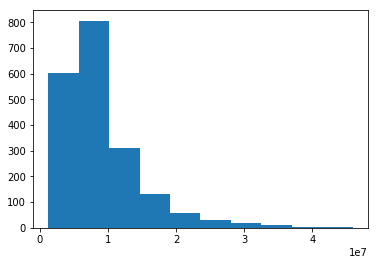

In [100]:
plt.hist(real_state_merged['price'], bins = 10)
plt.show()

Plotting the histogram of the standardised price variable:

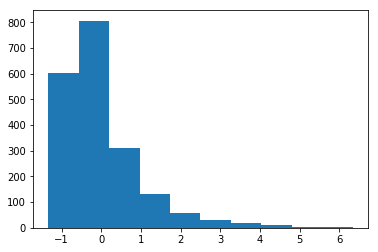

In [101]:
plt.hist(real_state_merged['std_price'], bins = 10)
plt.show()

Note that the distribution of the variable did not change with the standardisation. The price got rescaled from its original range in power of $10^7$ to roughly -3 to 3 (here mostly -2 to 6 for the exact range; but most of the values are still in the range of -3 to 3)

Plotting the original and standardised price on the same plot:

(<matplotlib.axes._subplots.AxesSubplot at 0x203ba2b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x203ba2b0>)

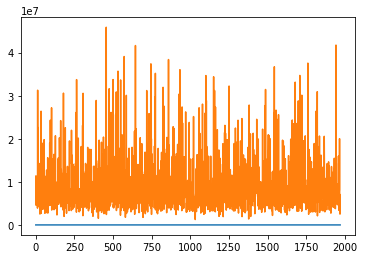

In [102]:
real_state_merged['std_price'].plot(), real_state_merged['price'].plot()

It is tough to infer anything from the above graph because of the very different scales of the original and standardised variables.  

Plotting the standardised variable alone:

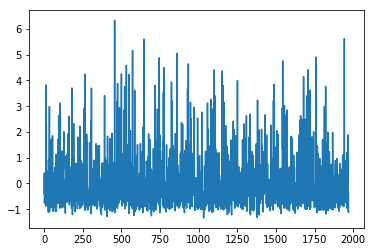

In [103]:
real_state_merged['std_price'].plot()

### 3.2 Min-max Normalization

In min-max normalization, the variables are rescaled between 0 and 1; the minimum value is assigned 0 and maximum value is assigned 1. This normalization is useful when we want shift the values of the variable in the range 0-1.

Performing min-max normalization for the price attribute using the MinMax Scaler from scikit library:

In [104]:
# min-max scaling
min_max_scaler = preprocessing.MinMaxScaler()
temp_arr = real_state_merged['price'].values.reshape(-1, 1) #returns a numpy array
real_state_merged['min_max_price'] = min_max_scaler.fit_transform(temp_arr)
# Check
real_state_merged['min_max_price'].head()

0    0.123024
1    0.227100
2    0.074244
3    0.091377
4    0.123180
Name: min_max_price, dtype: float64

It looks like the normalization happened correctly by observing the first few records.  

Seeing the summary of the normalized price:

In [105]:
real_state_merged['min_max_price'].describe()

count    1971.000000
mean        0.174273
std         0.130381
min         0.000000
25%         0.090258
50%         0.138186
75%         0.215062
max         1.000000
Name: min_max_price, dtype: float64

As we can see in the above summary, the minimum and maximum values of the normalised variable are 0 and 1 respectively.  

Plotting the histogram of the normalised variable:

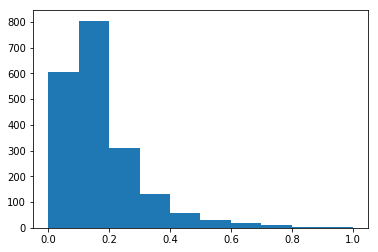

In [106]:
plt.hist(real_state_merged['min_max_price'], bins = 10)
plt.show()

Similar to the z-score standardisation, the histogram / distribution of the normalized price attribute is similar to the original price attribute. However, **the range of the values are now from 0 to 1**.  

Plotting the normalised and original price:  

(<matplotlib.axes._subplots.AxesSubplot at 0x204e8828>,
 <matplotlib.axes._subplots.AxesSubplot at 0x204e8828>)

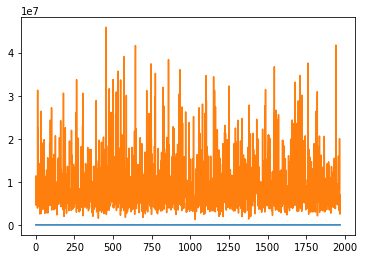

In [107]:
real_state_merged['min_max_price'].plot(), real_state_merged['price'].plot()

Same comment as the plot for z-score standardisation; this plot is also tough to read due to the different scales of the variables.  

Plotting the normalised variable alone:

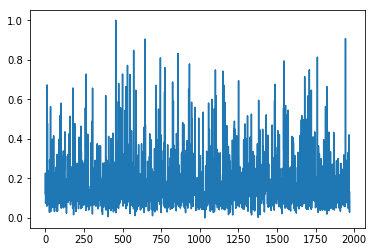

In [108]:
real_state_merged['min_max_price'].plot()

Plotting the z-score standardised price and min-max normalised price: 

(<matplotlib.axes._subplots.AxesSubplot at 0x20bb3240>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20bb3240>)

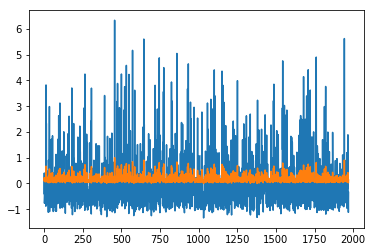

In [109]:
real_state_merged['std_price'].plot(),real_state_merged['min_max_price'].plot()

The key difference in the two normalisation techniques is the range with min-max normalized price having the range 0 to 1; while the z-score based standardised price having most of its values between -3 and 3

### 3.3 Log Transformation 

Log transformation is typically done to reduce the skewness in the data and to convert the data to a suitable form that is compatible with the assumptions of the model. It is also done to improve the interpretability of data. It is useful here as the values of property price are in thousands of dollars here; a logarithmic transformation of the price would make the prices very interpretable.

Performing the log transformation of price:

In [110]:
from math import log10, sqrt 

def log(n):
    return log10(n)

real_state_merged['log_price'] = real_state_merged['price'].apply(log)
real_state_merged['log_price'].head()

0    6.828853
1    7.056524
2    6.659441
3    6.726727
4    6.829304
Name: log_price, dtype: float64

It looks like the transformation happened correctly by observing the first few records.  

Seeing the summary of the tranformed price:

In [111]:
real_state_merged['log_price'].describe()

count    1971.000000
mean        6.885494
std         0.240852
min         6.096910
25%         6.722634
50%         6.870404
75%         7.035530
max         7.661813
Name: log_price, dtype: float64

All the values are now in single digits, which is much less skewed than before.

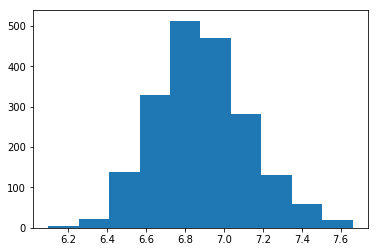

In [112]:
plt.hist(real_state_merged['log_price'], bins = 10)
plt.show()

Note that the distribution of the logarithm of price is **approximately normal** and the range is between 6.2 and 7.6. This transformation makes the attrbiute very interpretable and converts the price variable to a normal form, which is required for some models.  

Plotting the transformed and original price: 

(<matplotlib.axes._subplots.AxesSubplot at 0x20c76978>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20c76978>)

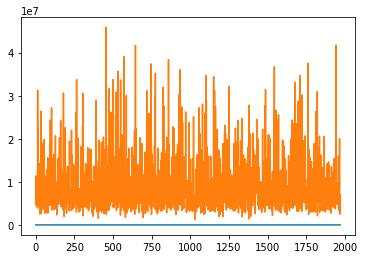

In [113]:
real_state_merged['log_price'].plot(), real_state_merged['price'].plot()

Plotting the transformed and z-score standardised price: 

(<matplotlib.axes._subplots.AxesSubplot at 0x20cf1b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20cf1b70>)

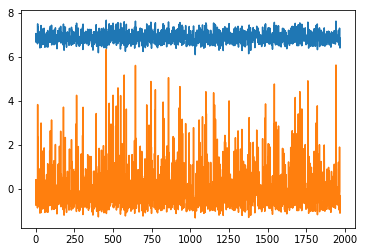

In [114]:
real_state_merged['log_price'].plot(), real_state_merged['std_price'].plot()

From the bove plot, we can see that the standardised prices are mostly between -3 and 3, while the logarithm of the prices are roughly between 6 and 8. The logarithmic transformation is much less spread than the z-score standardisation; the standard deviation of log price is 0.24 compared to 1 for z-score standardised. Hence, the logarithmic transformation brings the data points more closer here compared to z-score standardisation

### 3.4 Power Transformation 

Similar to other transformations, power transformations are done to improve the fit and stabilize the variances.  

Performing power transformation of the variables:

In [115]:
real_state_merged['pow_price'] = real_state_merged['price'] ** 2
real_state_merged['pow_price'].head()

0    4.546805e+13
1    1.297321e+14
2    2.083922e+13
3    2.840890e+13
4    4.556250e+13
Name: pow_price, dtype: float64

The values are now in very high powers of $10^{13}$ after the power transformation.  

Plotting the summary of the power tansformed price:

In [116]:
real_state_merged['pow_price'].describe()

count    1.971000e+03
mean     1.154371e+14
std      1.882266e+14
min      1.562500e+12
25%      2.787840e+13
50%      5.505640e+13
75%      1.177768e+14
max      2.106810e+15
Name: pow_price, dtype: float64

The standard deviation has increased after this transformation. This seems to have worsened the original variable, rather than improving it.   

Plotting the histogram of power transformed price:

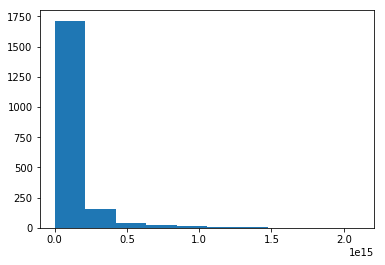

In [117]:
plt.hist(real_state_merged['pow_price'], bins = 10)
plt.show()

From the histogram, we can clearly see that the distribution seems to have worsened indicating that the power transformation is not very useful here.   

Plotting power price vs. original price:

(<matplotlib.axes._subplots.AxesSubplot at 0x20d8d8d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20d8d8d0>)

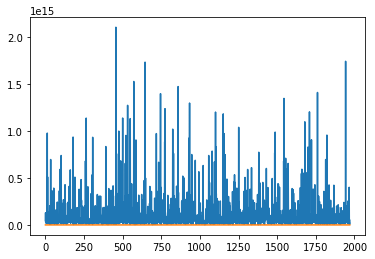

In [118]:
real_state_merged['pow_price'].plot(),real_state_merged['price'].plot()

### 3.5 Root Transformation

Similar to other transformations, root transformations are done to improve the fit and stabilize the variances.  

Performing root transformation of the variables:

In [119]:
def root(n):
    return sqrt(n)

real_state_merged['root_price'] = real_state_merged['price'].apply(root)
real_state_merged['root_price'].head()

0    2596.728711
1    3374.907406
2    2136.586062
3    2308.679276
4    2598.076211
Name: root_price, dtype: float64

The values of price are in 4 digits, compared to the order of $10^7$ of original price.  

Checking the summary of root transformed price:

In [120]:
real_state_merged['root_price'].describe()

count    1971.000000
mean     2883.240686
std       847.688114
min      1118.033989
25%      2297.825059
50%      2723.967694
75%      3294.313260
max      6774.953874
Name: root_price, dtype: float64

Plotting the histogram of root transformed price:

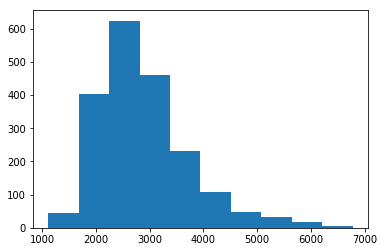

In [121]:
plt.hist(real_state_merged['root_price'], bins = 10)
plt.show()

The distribution of root transformed price appears to have gotten **closer to normal distribution**. However, the distribution is **right-skewed** and approximately normal.  

Plotting root transformed price vs. original price:

(<matplotlib.axes._subplots.AxesSubplot at 0x21e61b38>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21e61b38>)

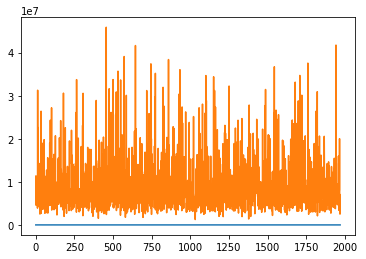

In [122]:
real_state_merged['root_price'].plot(),real_state_merged['price'].plot()

Plot is difficult to read due to the different scales of the variables.  

Plotting the root transformed variable alone:

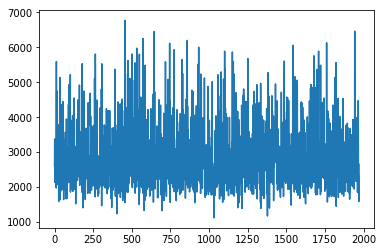

In [123]:
real_state_merged['root_price'].plot()

From the distributions of the different normalisations and transformations performed, the **log transformation of price attribute is the best as it converts the price to an approximately normal distribution and also makes the attribute more interpretable.**

### 3.6 Fitting a linear model for different forms of price attribute 

I am using the statsmodels API to do the linear regression as it provides a very good model summary similar to a summary in R, and also has a function to make partial regression plots of the target variable with predictor variables

Reference for statsmodels: 
Tim Dobbins, John Burke. *Predicting Housing Prices with Linear Regression using Python, pandas, and statsmodels*. Retrieved from https://www.learndatasci.com/tutorials/predicting-housing-prices-linear-regression-using-python-pandas-statsmodels/    

Before we do the modelling, check the basic summaries for the predictors: property_type, bathrooms, bedrooms and parking_space.

In [124]:
real_state_merged['property_type'].value_counts()

house    1971
Name: property_type, dtype: int64

All the values of **property_type** are equal to "house" making it a **redundant variable** in modelling. We can drop this predictor.

In [125]:
real_state_merged['bedrooms'].value_counts()

3    1050
4     529
2     283
5      96
1      13
Name: bedrooms, dtype: int64

In [126]:
real_state_merged['bathrooms'].value_counts()

1    973
2    857
3    141
Name: bathrooms, dtype: int64

In [127]:
real_state_merged['parking_space'].value_counts()

2    1053
1     548
0     242
3     128
Name: parking_space, dtype: int64

All the other predictors, apart from property_type seem fine to include in the model. 

Defining a **function** linear_model which takes the target column as the argument. The function **fits the linear model** using the predictors mentioned above and **prints the summary of the model**. The function also **plots the partial regression plots with the predictors.**

In [128]:
# linear model function to be re-used for all price forms
def linear_model(target):
    # fitting the model
    input_str = target + " ~ bedrooms + bathrooms + parking_space"
    lm_price = ols(input_str, data=real_state_merged).fit()
    # printing model summary
    print(lm_price.summary())
    # plotting partial regression plots
    fig = plt.figure(figsize=(20,12))
    fig = sm.graphics.plot_partregress_grid(lm_price, fig=fig)

Running the function for all the forms of price: std_price, min_max_price, log_price, pow_price, root_price

                            OLS Regression Results                            
Dep. Variable:              std_price   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     54.26
Date:                Fri, 26 Oct 2018   Prob (F-statistic):           1.09e-33
Time:                        18:43:45   Log-Likelihood:                -2718.4
No. Observations:                1971   AIC:                             5445.
Df Residuals:                    1967   BIC:                             5467.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.8440      0.094     -9.005

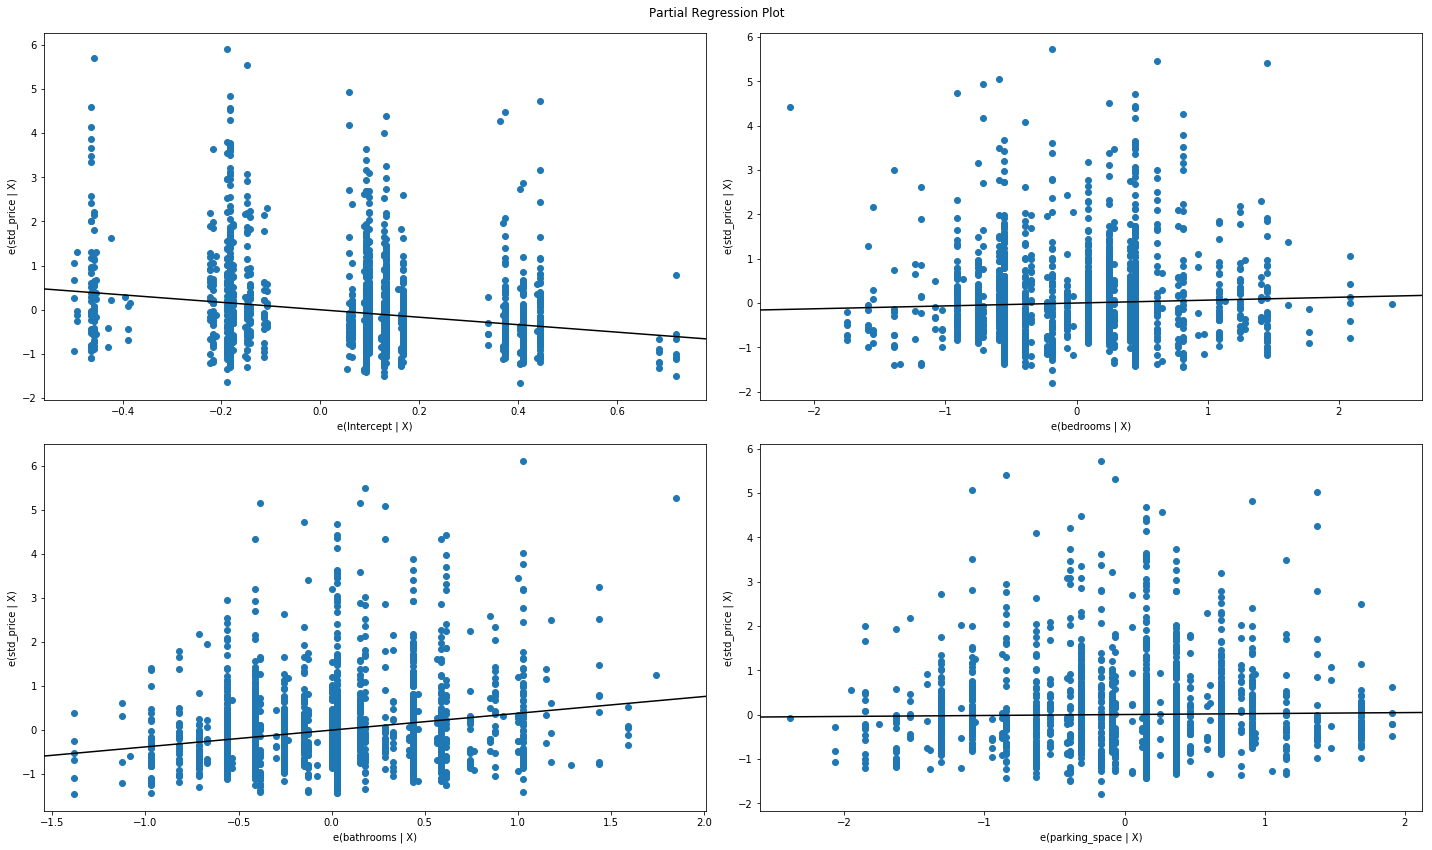

In [129]:
linear_model('std_price')

                            OLS Regression Results                            
Dep. Variable:          min_max_price   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     54.26
Date:                Fri, 26 Oct 2018   Prob (F-statistic):           1.09e-33
Time:                        18:43:46   Log-Likelihood:                 1297.6
No. Observations:                1971   AIC:                            -2587.
Df Residuals:                    1967   BIC:                            -2565.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0643      0.012      5.260

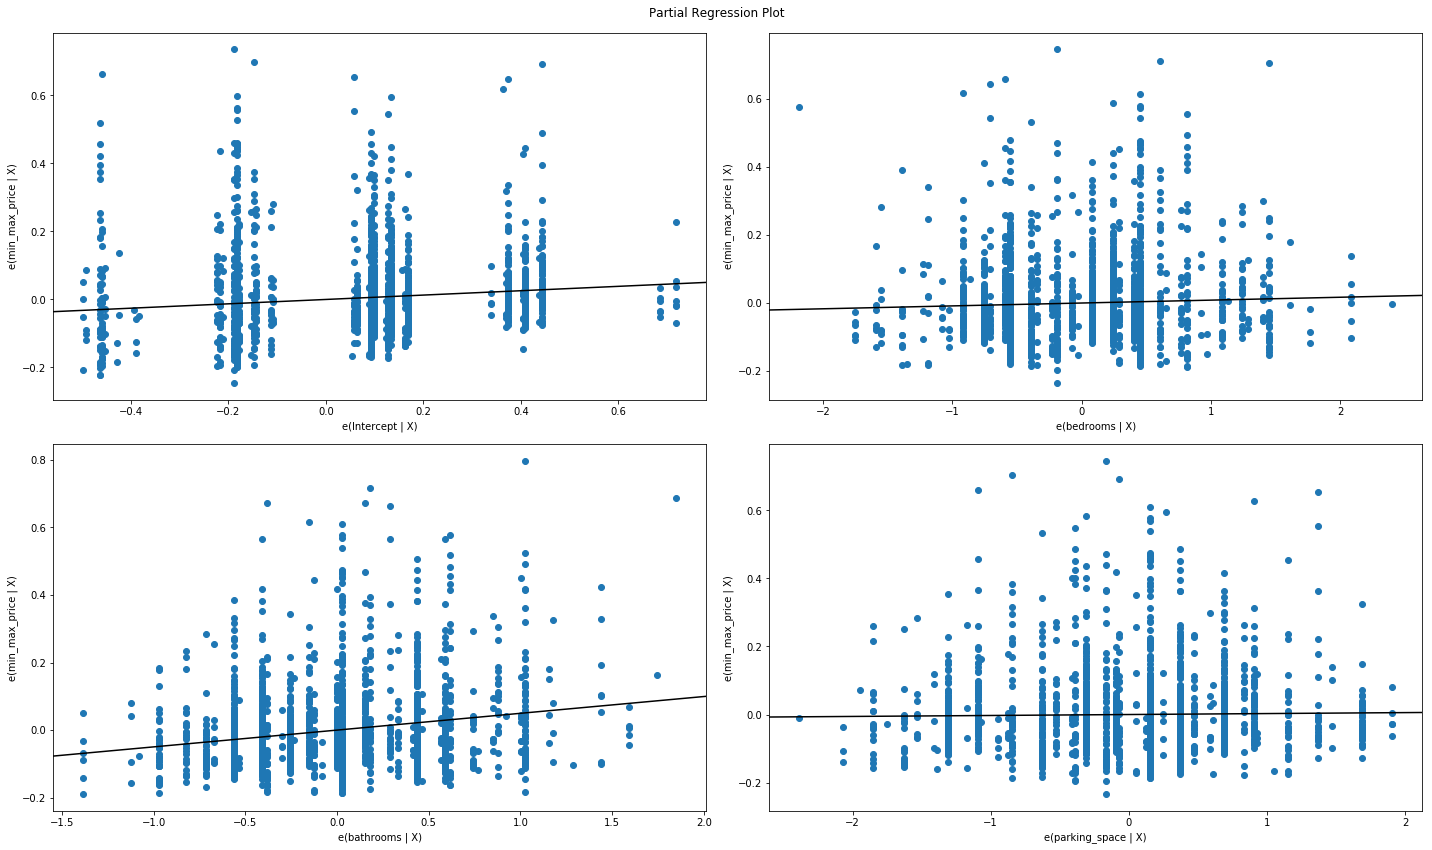

In [130]:
linear_model('min_max_price')

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     48.33
Date:                Fri, 26 Oct 2018   Prob (F-statistic):           3.89e-30
Time:                        18:43:47   Log-Likelihood:                 79.728
No. Observations:                1971   AIC:                            -151.5
Df Residuals:                    1967   BIC:                            -129.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.6900      0.023    295.193

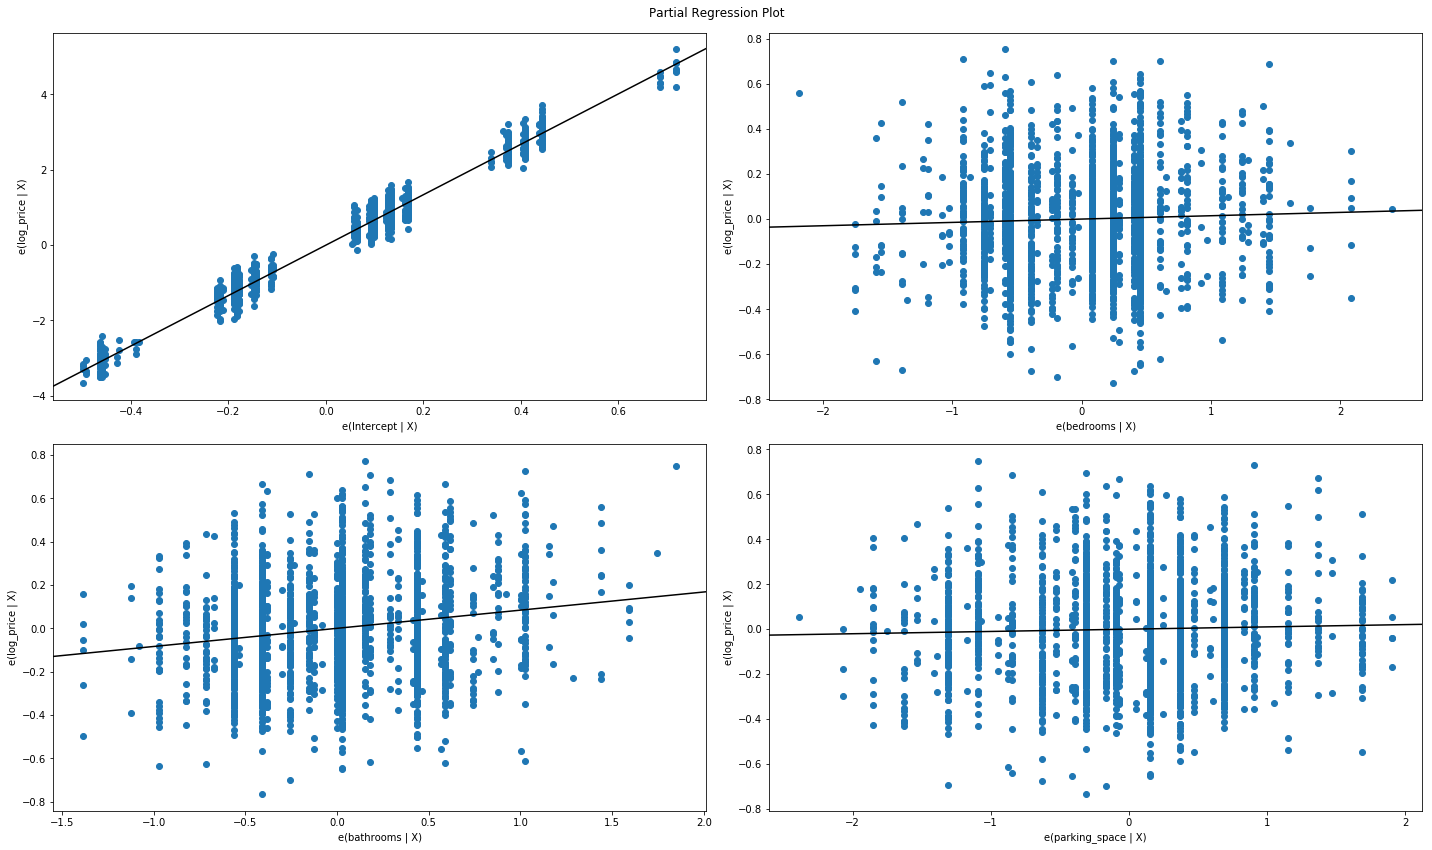

In [131]:
linear_model('log_price')

                            OLS Regression Results                            
Dep. Variable:              pow_price   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     43.69
Date:                Fri, 26 Oct 2018   Prob (F-statistic):           2.48e-27
Time:                        18:43:47   Log-Likelihood:                -67517.
No. Observations:                1971   AIC:                         1.350e+05
Df Residuals:                    1967   BIC:                         1.351e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -2.67e+13   1.78e+13     -1.502

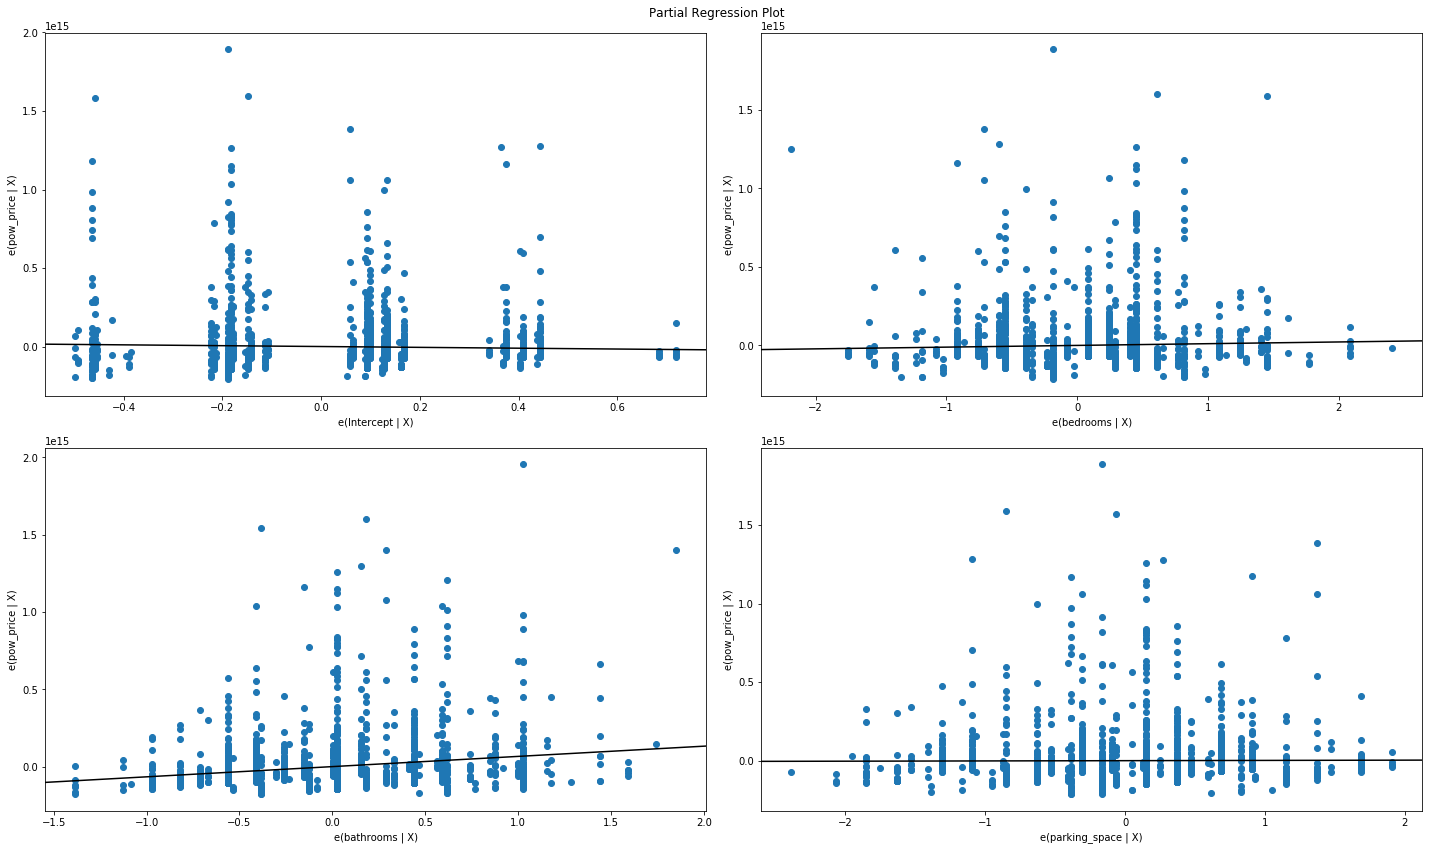

In [132]:
linear_model('pow_price')

                            OLS Regression Results                            
Dep. Variable:             root_price   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     53.66
Date:                Fri, 26 Oct 2018   Prob (F-statistic):           2.45e-33
Time:                        18:43:48   Log-Likelihood:                -16008.
No. Observations:                1971   AIC:                         3.202e+04
Df Residuals:                    1967   BIC:                         3.205e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2166.7089     79.463     27.267

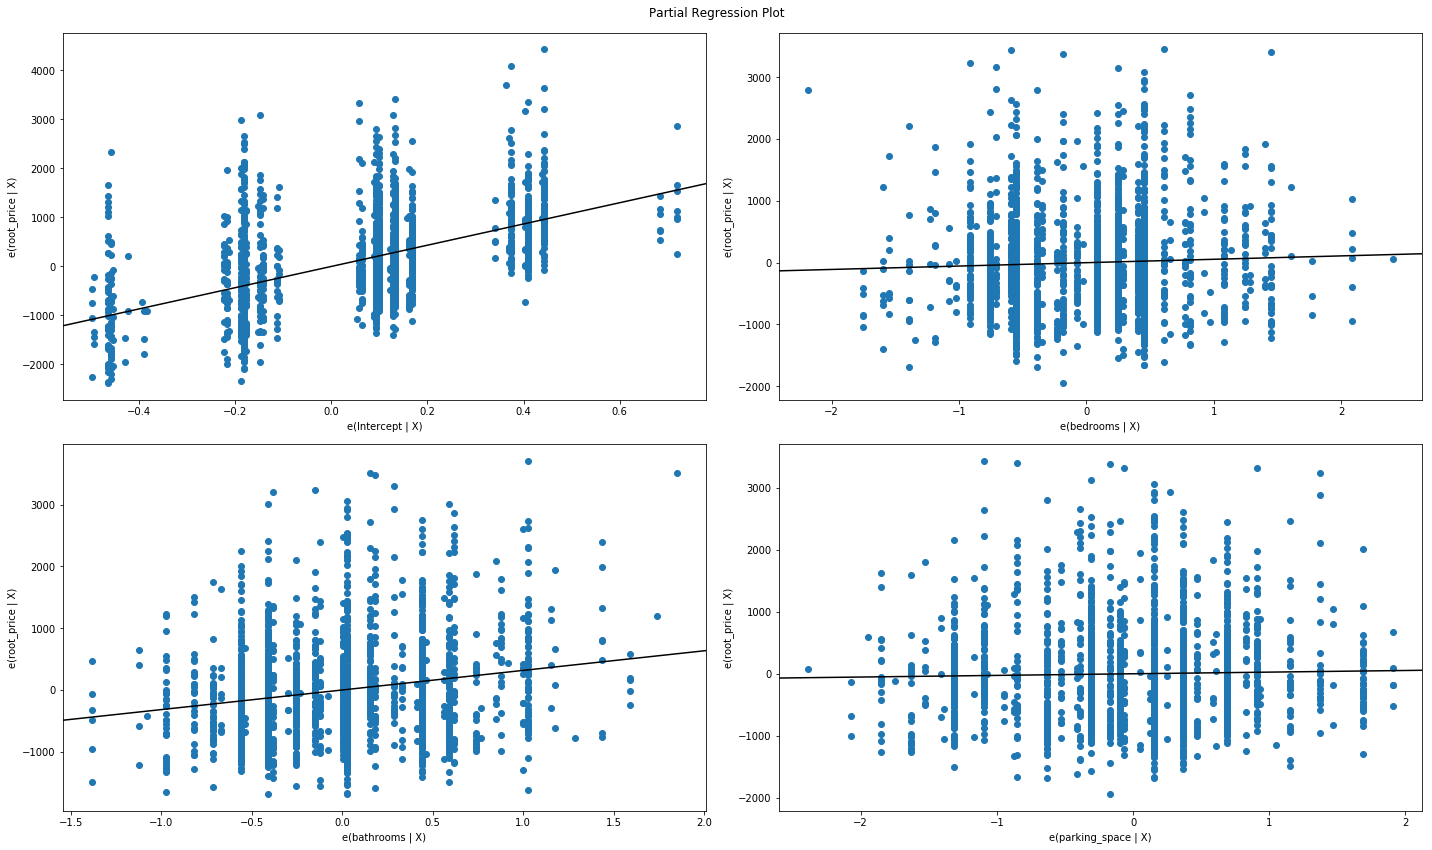

In [133]:
linear_model('root_price')

The r-squared values for all the linear models are very similar. The partial regression plots for log_price are slightly more linear compared to other transformations. Hence, it looks like the **logarithmic transformation is the best** for fitting a linear model for price using bedrooms, bathrooms and parking_space as predictors.

**Overall, I would recommend the logarithmic transformation of price as it converts price to an approximately normal distirbution, makes it more interpretable and has the best linear fit with the predictors compared to other transformations. However, for the linear model, the predictors can be modified to increase the predicting ability of the model**

## 4. Summary

* Data Integration: The 7 data files about the property prices were successfully integrated into a consolidated data file. There were various challenges during the integration with differences in schema in the data files, different formats of the data files, and duplicates in the integrated data file. The key learnings from the integration process were to follow a structured approach; and integrate the files one at a time. The order of integration is also somewhat important as you need to integrate the real estate files first and then add features to the integrated data frame using the other data files. We can observe that we need to first integrate the data files such that you cover all possible records, and then you can add columns to the data frame. Following an incorrect order will result in rework.  

* Data Reshaping: Several normalisations and transformations were applied to the price attribute. The logarithmic transformation of price was found to be best as it converted the price attribute to an approximately normal form; it also made the attribute more interpretable and had relatively the best linear fit with the specified predictors. The key learnings during this task were to observe the importance of normalisations and transformations in bringing the attributes to the same scale, reducing skewness in the attribute and converting the attribute to a suitable form for modelling. 

## 5. References
1. Michael0x2a (2013, October 16). *Distance between two coordinates* [Response to]. Retrieved from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
2. A.Kot (2017, January 17). *Set order of columns in pandas dataframe* [Response to]. Retrieved from https://stackoverflow.com/questions/41968732/set-order-of-columns-in-pandas-dataframe
- Tim Dobbins, John Burke. *Predicting Housing Prices with Linear Regression using Python, pandas, and statsmodels*. Retrieved from https://www.learndatasci.com/tutorials/predicting-housing-prices-linear-regression-using-python-pandas-statsmodels/
